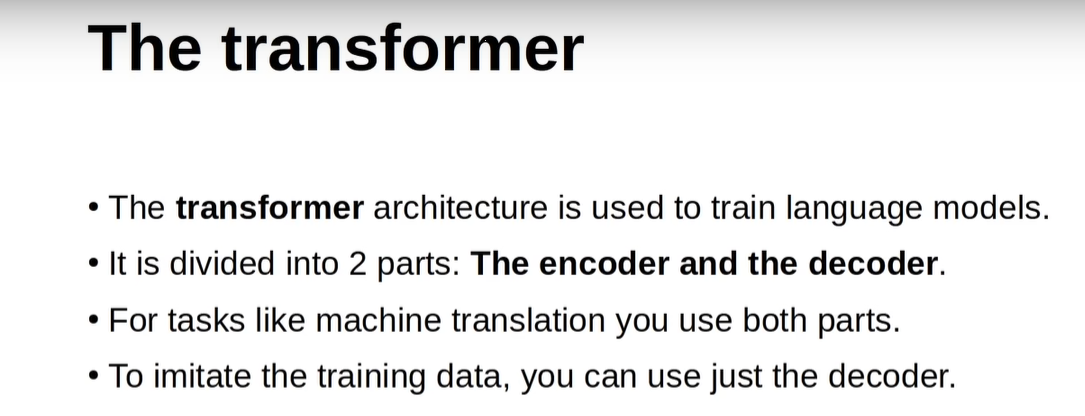 


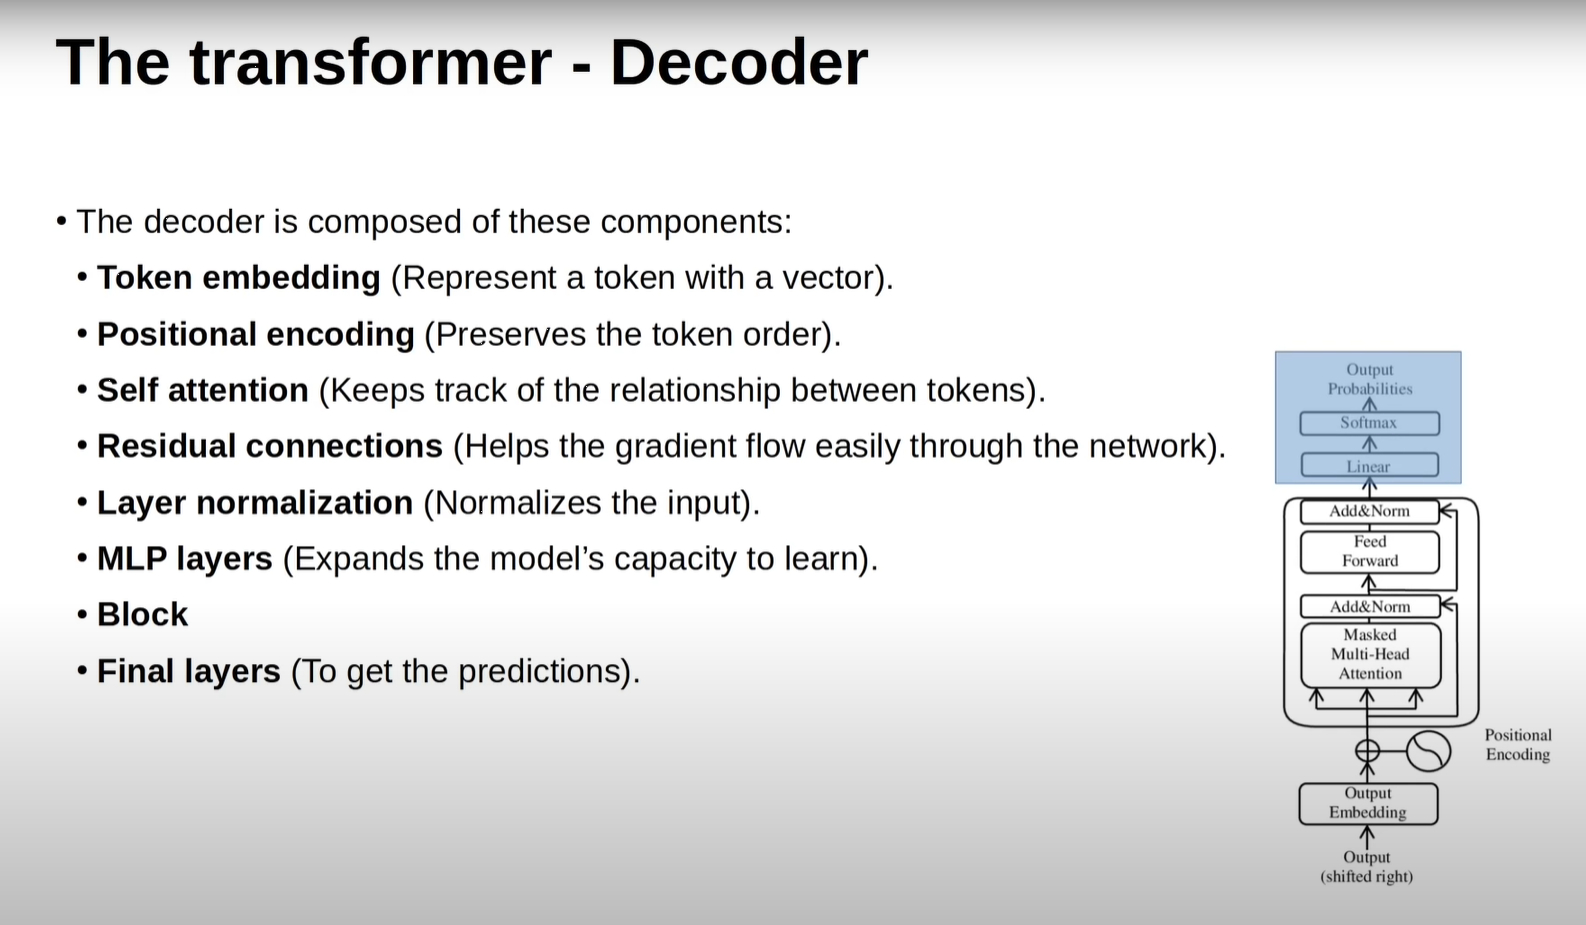

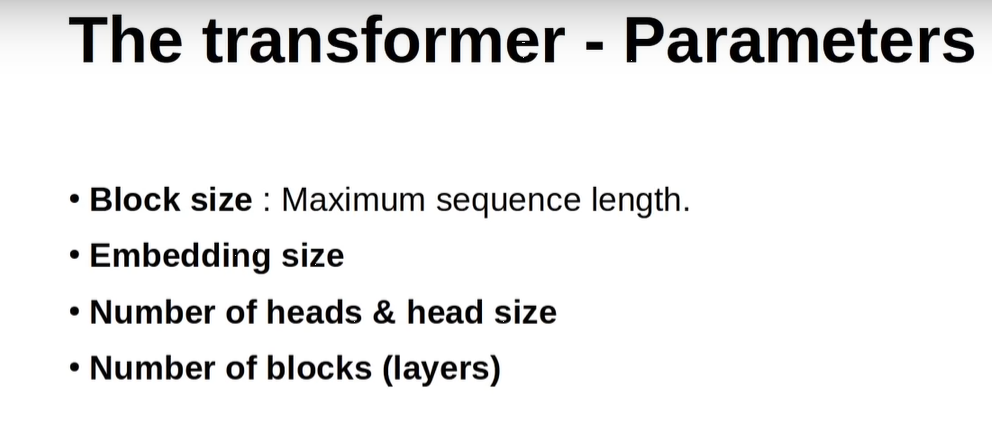

# Load the Tokenizer

In [15]:
import sys
sys.path.append('..')

In [16]:
from minbpe import BasicTokenizer
tokenizer=BasicTokenizer()
tokenizer.load(model_file="../output/tokenizer/my_tokenizer.model")

In [17]:
def get_vocab_size(tokenizer: BasicTokenizer)->int:
    vocab=tokenizer.vocab
    special_tokens=tokenizer.special_tokens

    return len(vocab) + len(special_tokens)

# Creating the model

This model is based on [Andrej Karpathy's](https://github.com/karpathy/ng-video-lecture/blob/master/gpt.py) implementation of the GPT-2 model.

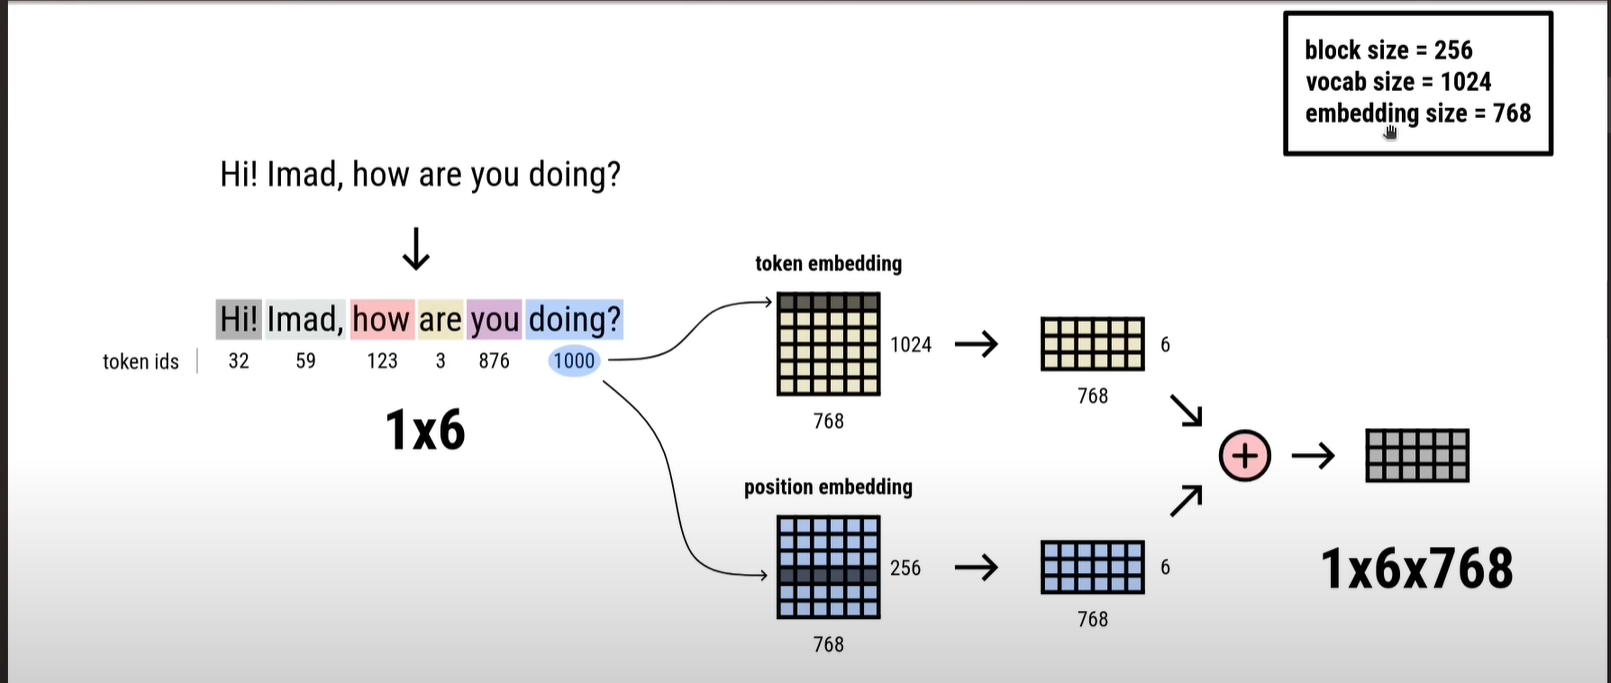

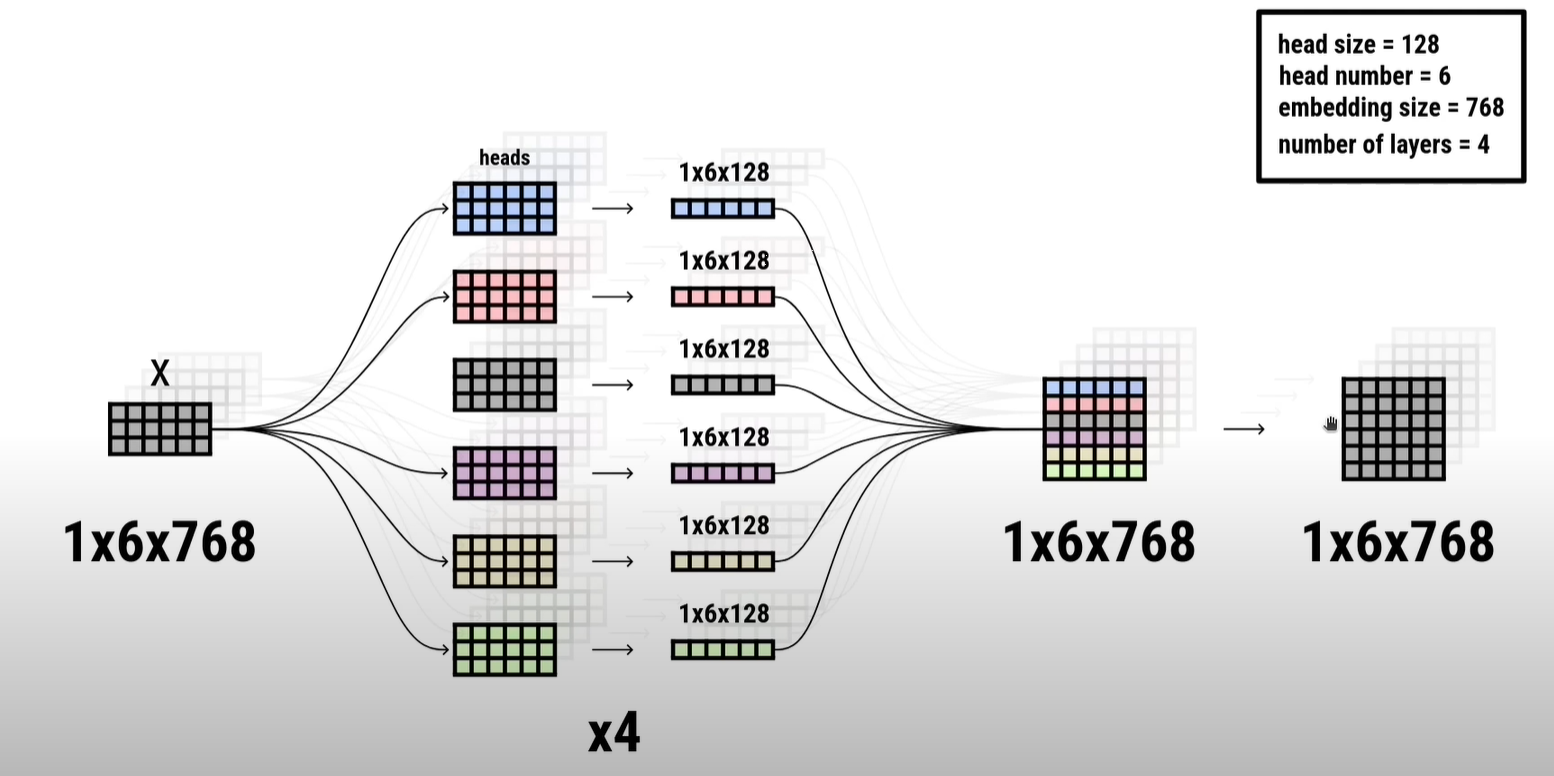

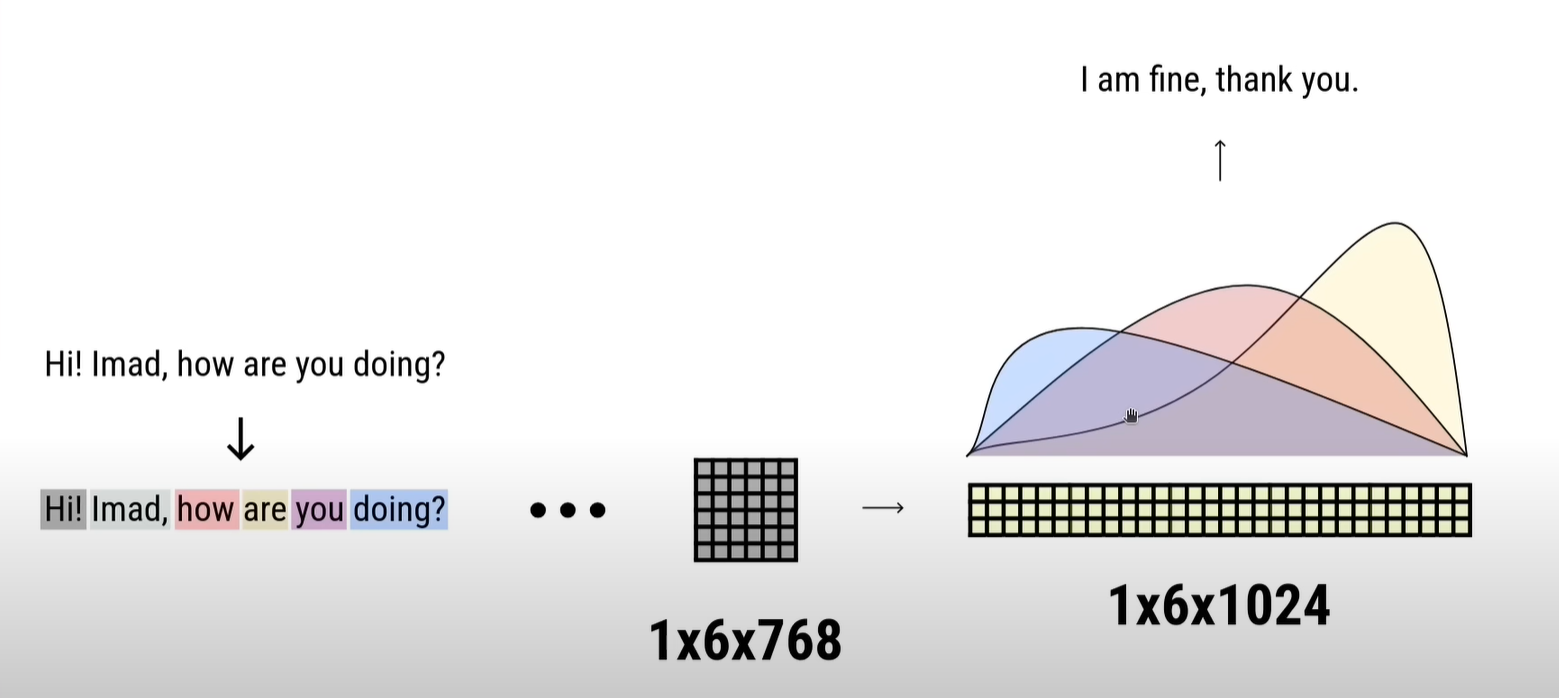

Code

In [18]:
import torch
torch.manual_seed(3647)
block_size=256
n_embd=384
n_head=6
n_layer=6
dropout=0.2
vocab_size=get_vocab_size(tokenizer)
device='cuda' if torch.cuda.is_available() else 'cpu'

In [19]:
device

'cpu'

1. Head

In [20]:
from typing import Optional, Tuple
import torch
import torch.nn as nn
from torch.nn import functional as F

In [21]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size: int) -> None:
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(
            torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        _, T, _ = x.shape
        k = self.key(x)   # (B,T,hs) projecting to get k
        q = self.query(x)  # (B,T,hs) projecting  to get q
        # compute attention scores ("affinities")
        # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        weights = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5
        weights = weights.masked_fill(
            self.tril[:T, :T] == 0, float('-inf'))  # (B, T, T) triangular mask
        weights = F.softmax(weights, dim=-1)  # (B, T, T)
        weights = self.dropout(weights) # dropout to precent overfitting
        # perform the weighted aggregation of the values
        v = self.value(x)  # (B,T,hs)
        out = weights @ v  # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out


---

## 🧠 Understanding the `Head` Class: A Single Head of Self-Attention

```python
class Head(nn.Module):
    """ One head of self-attention """
```

This defines a class `Head` which represents **one attention head** in a **multi-head self-attention** mechanism. It inherits from `nn.Module`, which is the base class for all neural network modules in PyTorch.

---

# What is Self-Attention?

Self-attention is a mechanism that lets a model **look at all parts of an input sequence at once** and figure out which parts are important relative to each other.

Imagine you have a sentence, and you want the model to understand how each word relates to every other word in that sentence. Self-attention helps the model weigh the importance of every other word when interpreting a particular word.

---

## How does it work?

For each word in the input:

1. It compares that word to every other word.
2. It assigns a **weight** to each comparison — basically, “how important is that other word for understanding this word?”
3. It then creates a weighted combination (or mix) of all the other words based on those weights.
4. This combined info helps the model capture context, like word relationships or dependencies, no matter how far apart they are in the sequence.

---

## Why is it useful?

- It helps capture long-range dependencies — for example, understanding that “it” refers to “the movie” even if they are far apart.
- It’s **parallelizable** (unlike older methods like RNNs), so it can be faster.
- It’s the backbone of models like **Transformers**, which power GPT, BERT, and many others.

---

## Quick analogy:

Think of self-attention like a group discussion where every participant (word) listens carefully to everyone else and decides whose opinion is most relevant to understand what’s going on.

---



### 🔧 `__init__` Method (Constructor)

```python
def __init__(self, head_size: int) -> None:
```

* `head_size`: The size (number of features) for this attention head. It determines how many dimensions the key, query, and value vectors will have for this head.

```python
    super().__init__()
```

Calls the constructor of the base class (`nn.Module`), required for all PyTorch modules.

```python
    self.key = nn.Linear(n_embd, head_size, bias=False)
    self.query = nn.Linear(n_embd, head_size, bias=False)
    self.value = nn.Linear(n_embd, head_size, bias=False)
```

* These are linear layers that project the input into **key**, **query**, and **value** vectors.
* `n_embd` (defined elsewhere in your code) is the size of the input embedding.
* `bias=False` removes the bias term for simplicity.

```python
    self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
```

* Creates a **lower triangular matrix** (`tril`) of shape `[block_size, block_size]`.
* This is used to **mask future tokens** in causal/self-attention (prevents looking ahead).

```python
    self.dropout = nn.Dropout(dropout)
```

* Applies dropout for regularization to prevent overfitting.
* `dropout` is a float between 0 and 1 (e.g. 0.1), defined globally.

---

### 🚀 `forward` Method (How the Layer is Applied)

```python
def forward(self, x: torch.Tensor) -> torch.Tensor:
```

* `x`: Input tensor of shape `(B, T, C)`

  * `B` = Batch size
  * `T` = Time steps (sequence length)
  * `C` = Channels = `n_embd` (embedding size)

```python
    _, T, _ = x.shape
```

Extracts the sequence length `T` from the input shape.

```python
    k = self.key(x)   # (B, T, head_size)
    q = self.query(x) # (B, T, head_size)
```

Projects the input into **key** and **query** vectors using the linear layers.

```python
    weights = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5
```

* Performs scaled dot-product attention:

  * `q @ k.T` computes the similarity (attention score) between queries and keys.
  * `* k.shape[-1]**-0.5` scales the result to stabilize gradients (as in the Transformer paper).

```python
    weights = weights.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
```

* Applies the **causal mask**: sets the upper triangle (future tokens) to `-inf` so their softmax becomes zero.
* Ensures **only past and present tokens** are attended to.

```python
    weights = F.softmax(weights, dim=-1)
```

* Converts scores to probabilities using softmax.
* Output shape: `(B, T, T)` — attention weights from each token to every other token before it.

```python
    weights = self.dropout(weights)
```

Applies dropout to attention weights for regularization.

```python
    v = self.value(x)  # (B, T, head_size)
```

Projects the input into **value** vectors.

```python
    out = weights @ v  # (B, T, T) @ (B, T, head_size) -> (B, T, head_size)
```

* Performs a weighted sum of the values using the attention weights.
* Output has the same shape as query/key/value: `(B, T, head_size)`.

```python
    return out
```

Returns the final attention output for this head.

---

### 📌 Summary

| Component                      | Purpose                                    |
| ------------------------------ | ------------------------------------------ |
| `nn.Linear`                    | Project input to query, key, and value     |
| `register_buffer('tril', ...)` | Causal masking for self-attention          |
| `Dropout`                      | Regularization                             |
| `q @ k.T`                      | Compute similarity scores                  |
| `Softmax`                      | Convert scores to probabilities            |
| `@ v`                          | Aggregate value vectors based on attention |

---

### ✅ What You Can Pass as `head_size`

You can pass any **positive integer** as `head_size` that evenly divides the total embedding size (`n_embd`) if you are using multiple heads. For example:

* If `n_embd = 512`, and you use 8 heads → each `head_size = 64`.

This keeps dimensions consistent when outputs from multiple heads are concatenated.

---




# 2. Multi Head Attention

In [22]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads: int, head_size: int) -> None:
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.projection = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.projection(out))
        return out


---

## 🎯 `MultiHeadAttention` — Parallel Self-Attention Heads

```python
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """
```

This class implements **multi-head self-attention** — a key idea from the Transformer architecture. Instead of using just one attention mechanism, it uses **multiple `Head` instances in parallel**, then combines their outputs.

---

### 🔧 `__init__` Method (Constructor)

```python
def __init__(self, num_heads: int, head_size: int) -> None:
```

* `num_heads`: How many attention heads to run in parallel.
* `head_size`: The dimensionality of each individual attention head.

  * So, total attention output size = `num_heads × head_size`

```python
    super().__init__()
```

Initializes the PyTorch base class (`nn.Module`).

```python
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
```

* Creates a list of `Head` modules.
* Each `Head` does self-attention separately on the same input.

```python
    self.projection = nn.Linear(head_size * num_heads, n_embd)
```

* After concatenating outputs from all heads, this **linear projection** maps it back to the original embedding size (`n_embd`).
* This mixes information from all heads.

```python
    self.dropout = nn.Dropout(dropout)
```

Adds dropout for regularization.

---

### 🚀 `forward` Method (How the Layer is Applied)

```python
def forward(self, x: torch.Tensor) -> torch.Tensor:
```

* `x`: Input tensor of shape `(B, T, n_embd)`

  * `B` = Batch size
  * `T` = Sequence length (time steps)
  * `n_embd` = Embedding size

```python
    out = torch.cat([h(x) for h in self.heads], dim=-1)
```

* Runs each `Head` on the input `x`.
* Each head returns output of shape `(B, T, head_size)`.
* `torch.cat(..., dim=-1)` concatenates along the feature/channel dimension → final shape: `(B, T, head_size × num_heads)`.

```python
    out = self.dropout(self.projection(out))
```

* Applies the linear projection to mix information from all heads.
* Then applies dropout.

```python
    return out
```

Returns the combined multi-head attention output, with the same shape as the input: `(B, T, n_embd)`.

---

### 🧠 Why Multi-Head?

Multiple attention heads allow the model to:

* Look at different **positions** in the sequence.
* Learn different types of **relationships** between tokens.
* Focus on **multiple subspaces** of the embedding.

Each head sees the same input but learns different attention patterns.

---

### 📌 Summary Table

| Component                | Purpose                                              |
| ------------------------ | ---------------------------------------------------- |
| `Head(head_size)`        | One attention head                                   |
| `nn.ModuleList([...])`   | List of heads in parallel                            |
| `torch.cat(..., dim=-1)` | Combine all head outputs                             |
| `projection`             | Maps combined output back to original embedding size |
| `dropout`                | Helps prevent overfitting                            |

---

### ✅ What You Can Pass

* `num_heads`: any integer ≥ 1
* `head_size`: must satisfy `head_size × num_heads == n_embd`

  * For example, if `n_embd = 512` and you use `num_heads = 8`, then `head_size = 64`.

---




# 3. Block

In [23]:
class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd: int) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd: int, n_head: int) -> None:
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.self_attention = MultiHeadAttention(n_head, head_size)
        self.feed_forward = FeedForward(n_embd)
        self.layer_norm_1 = nn.LayerNorm(n_embd)
        self.layer_norm_2 = nn.LayerNorm(n_embd)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.self_attention(self.layer_norm_1(x))
        x = x + self.feed_forward(self.layer_norm_2(x))
        return x


---

## 🔧 `FeedForward` Class — Pointwise Neural Network

```python
class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """
```

This class defines a **feed-forward neural network** used inside each Transformer block. It processes each token **independently** after the attention step.

### 🔧 `__init__` Method

```python
def __init__(self, n_embd: int) -> None:
```

* `n_embd`: Size of the embedding (i.e., number of features per token).

```python
    self.net = nn.Sequential(
        nn.Linear(n_embd, 4 * n_embd),
        nn.ReLU(),
        nn.Linear(4 * n_embd, n_embd),
        nn.Dropout(dropout),
    )
```

* **2 linear layers**:

  * Expands embedding size to `4×` for more capacity (as per Transformer paper).
  * Applies **ReLU** activation (non-linearity).
  * Then reduces it back to original size.
* Adds **dropout** for regularization.

### 🚀 `forward` Method

```python
def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.net(x)
```

* Input: `(B, T, n_embd)` — batch of token embeddings.
* Output: Same shape, processed independently for each token.

---

## 🧱 `Block` Class — Full Transformer Block

```python
class Block(nn.Module):
    """ Transformer block: communication followed by computation """
```

Each `Block` is a standard **Transformer block**:

1. **Communication** via multi-head self-attention.
2. **Computation** via feed-forward network.
3. Plus two **layer normalizations** and **residual connections**.

---

### 🔧 `__init__` Method

```python
def __init__(self, n_embd: int, n_head: int) -> None:
```

* `n_embd`: Total embedding dimension.
* `n_head`: Number of attention heads to split the embedding into.

```python
    head_size = n_embd // n_head
```

* Computes the size of each attention head (must divide evenly).

```python
    self.self_attention = MultiHeadAttention(n_head, head_size)
```

* Multi-head attention for **token-to-token interaction**.

```python
    self.feed_forward = FeedForward(n_embd)
```

* Simple 2-layer network applied to each token independently.

```python
    self.layer_norm_1 = nn.LayerNorm(n_embd)
    self.layer_norm_2 = nn.LayerNorm(n_embd)
```

* **Layer normalization** helps stabilize and speed up training.
* Applied **before** the sub-layers (pre-norm style).

---

### 🚀 `forward` Method

```python
def forward(self, x: torch.Tensor) -> torch.Tensor:
```

* Input: Tensor of shape `(B, T, n_embd)`

```python
    x = x + self.self_attention(self.layer_norm_1(x))
```

* Apply **layer norm**.
* Then run self-attention.
* Add original input (**residual connection**).

```python
    x = x + self.feed_forward(self.layer_norm_2(x))
```

* Normalize again.
* Apply feed-forward network.
* Add original input again (**another residual connection**).

```python
    return x
```

* Final output is the same shape as input: `(B, T, n_embd)`

---

### 🔁 Summary of Transformer Block Flow

```
x --> LayerNorm --> Self-Attention --> + residual -->
   --> LayerNorm --> FeedForward     --> + residual --> output
```

---

### ✅ What You Can Pass

#### For `FeedForward(n_embd)`:

* `n_embd`: The embedding size of your model.

#### For `Block(n_embd, n_head)`:

* `n_embd`: Total embedding dimension (e.g. 512 or 768).
* `n_head`: Number of attention heads (must divide `n_embd` evenly).

---

### 🧠 Why Use LayerNorm and Residuals?

* **LayerNorm** stabilizes training by normalizing activations.
* **Residuals** help preserve gradients and allow deeper models to be trained.

---



# Assembling the language model

In [24]:
class GPTLanguageModel(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(
            *[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.final_layer_norm = nn.LayerNorm(n_embd)
        self.final_linear_layer = nn.Linear(n_embd, vocab_size)

        self.apply(self._init_weights)

    def _init_weights(self, module: nn.Module) -> None:
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, input_tokens: torch.Tensor, targets: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        """
        Forward pass of the model.

        Args:
            input_tokens: Tensor of token indices of shape (batch_size, sequence_length)
            targets: Optional tensor of target token indices of same shape as input_tokens

        Returns:
            Tuple of (logits, loss) where logits has shape (batch_size, sequence_length, vocab_size)
            and loss is optional cross-entropy loss if targets are provided
        """

        B, T = input_tokens.shape

        # input_tokens and targets are both (B,T) tensor of integers
        token_embedding = self.token_embedding_table(input_tokens)  # (B,T,C)
        positional_embedding = self.position_embedding_table(
            torch.arange(T, device=device))  # (T,C)
        x = token_embedding + positional_embedding  # (B,T,C)
        x = self.blocks(x)  # (B,T,C)
        x = self.final_layer_norm(x)  # (B,T,C)
        logits = self.final_linear_layer(x)  # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, input_tokens: torch.Tensor, max_new_tokens: int) -> torch.Tensor:
        """
                Generate new tokens given a context.

                Args:
                        input_tokens: Starting token indices of shape (batch_size, sequence_length)
                        max_new_tokens: Number of new tokens to generate

                Returns:
                        Tensor of token indices of shape (batch_size, sequence_length + max_new_tokens)
                """

        # input_tokens is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop input_tokens to the last block_size tokens
            cropped_input = input_tokens[:, -block_size:]
            # get the predictions
            logits, _ = self(cropped_input)
            # focus only on the last time step
            logits = logits[:, -1, :]  # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)  # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            # append sampled index to the running sequence
            input_tokens = torch.cat(
                (input_tokens, idx_next), dim=1)  # (B, T+1)
        return input_tokens


# 🧠 Understanding `GPTLanguageModel` Code

We are building a **mini GPT-like Transformer model**.  
This class is a simplified version of how GPT (Generative Pretrained Transformer) works.

---

## 📦 Class: `GPTLanguageModel`

### 1. `__init__` (The Setup / Layers)
```python
def __init__(self) -> None:
    super().__init__()
    # each token directly reads off the logits for the next token from a lookup table
    self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
    self.position_embedding_table = nn.Embedding(block_size, n_embd)
    self.blocks = nn.Sequential(
        *[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
    self.final_layer_norm = nn.LayerNorm(n_embd)
    self.final_linear_layer = nn.Linear(n_embd, vocab_size)
```

* **`nn.Embedding(vocab_size, n_embd)`**
  Converts each **word/token (integer index)** into a **vector** of size `n_embd` (embedding dimension).
  Think: "word → vector".

* **`nn.Embedding(block_size, n_embd)`**
  Learns **positional embeddings** so the model knows the order of words in a sentence.
  Example: "dog bites man" ≠ "man bites dog".

* **`nn.Sequential([...])`**
  A stack of `Block`s. Each block = **Transformer block** (multi-head self-attention + feed-forward network).
  `n_layer` = how many Transformer layers.
  `n_head` = number of attention heads in each block.

* **`nn.LayerNorm(n_embd)`**
  Normalizes the output so training is stable.

* **`nn.Linear(n_embd, vocab_size)`**
  Maps from hidden vector → logits over vocabulary.
  (Tells model which word comes next.)

---

### 2. `_init_weights` (Weight Initialization)

```python
def _init_weights(self, module: nn.Module) -> None:
    if isinstance(module, nn.Linear):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        if module.bias is not None:
            torch.nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
```

* Initializes weights with small random numbers (important for training).
* Linear layers and embeddings get values from a normal distribution.
* Bias = 0 initially.

---

### 3. `forward` (Forward Pass)

```python
def forward(self, input_tokens, targets=None):
    B, T = input_tokens.shape
    token_embedding = self.token_embedding_table(input_tokens)  # (B,T,C)
    positional_embedding = self.position_embedding_table(torch.arange(T, device=device))  # (T,C)
    x = token_embedding + positional_embedding  # (B,T,C)
    x = self.blocks(x)  # (B,T,C)
    x = self.final_layer_norm(x)  # (B,T,C)
    logits = self.final_linear_layer(x)  # (B,T,vocab_size)
```

Steps:

1. **Token embedding:** Convert words to vectors. `(B,T,C)`

   * `B` = batch size
   * `T` = sequence length
   * `C` = embedding dimension (`n_embd`)

2. **Positional embedding:** Add position info so order matters.

3. **Add embeddings:** token + position = combined representation.

4. **Transformer blocks:** Pass through multiple self-attention layers.

5. **LayerNorm + Linear:** Normalize → map to vocab probabilities.

---

#### 🎯 Loss Calculation

```python
if targets is None:
    loss = None
else:
    B, T, C = logits.shape
    logits = logits.view(B*T, C)
    targets = targets.view(B*T)
    loss = F.cross_entropy(logits, targets)
```

* If `targets` are given → compute **cross-entropy loss**.
* If not → just return logits (useful for text generation).

---

### 4. `generate` (Text Generation)

```python
def generate(self, input_tokens, max_new_tokens):
    for _ in range(max_new_tokens):
        cropped_input = input_tokens[:, -block_size:]
        logits, _ = self(cropped_input)
        logits = logits[:, -1, :]  # only last step
        probs = F.softmax(logits, dim=-1)  # turn into probabilities
        idx_next = torch.multinomial(probs, num_samples=1)  # sample next word
        input_tokens = torch.cat((input_tokens, idx_next), dim=1)  # append
    return input_tokens
```

How generation works:

1. Take the input sentence (`input_tokens`).
2. Pass through model → get logits.
3. Focus only on the **last word prediction**.
4. Apply **softmax** → probabilities over vocab.
5. Sample the next word (`torch.multinomial`).
6. Append it to sequence.
7. Repeat until `max_new_tokens` are generated.

---

## 📌 Summary of Parameters

* **`vocab_size`** → Total number of unique tokens (words/chars).
* **`n_embd`** → Embedding size (dimensionality of word vectors).
* **`block_size`** → Max sequence length (context window).
* **`n_layer`** → Number of Transformer blocks.
* **`n_head`** → Number of attention heads inside each block.

---

## 🚀 Big Picture

* Input tokens → embeddings (word + position).
* Pass through stacked Transformer blocks.
* Normalize and map to logits.
* Predict next word using cross-entropy loss.
* Use `generate` to sample new text step by step.

---




# Parameter and dummy input


In [25]:
model = GPTLanguageModel()
model = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

11.53409 M parameters



# 📊 Parameters in GPTLanguageModel + Dummy Input

---

## 🔢 Counting Parameters
```python
model = GPTLanguageModel()
model = model.to(device)

# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')
```

### ✅ Explanation:

* **`model.parameters()`** → gives all learnable weights (embeddings, linear layers, etc.).
* **`p.numel()`** → counts how many numbers (elements) are inside that parameter tensor.
* **`sum(...)`** → adds up all weights in the model.
* **`/1e6`** → converts the count into **millions (M)**, since large models have millions of parameters.

So this line prints:

```
XX M parameters
```

Example:
A small GPT might have **10M parameters**, but GPT-3 has **175B parameters**.

---

## 🏷️ Where Parameters Come From?

1. **Token Embedding Table**
   Shape: `(vocab_size, n_embd)`
   Parameters = `vocab_size * n_embd`

2. **Positional Embedding Table**
   Shape: `(block_size, n_embd)`
   Parameters = `block_size * n_embd`

3. **Each Transformer Block**
   Includes:

   * Multi-head self-attention (weights for Q, K, V, and output projection).
   * Feed-forward layers (2 Linear layers).
   * LayerNorm parameters (scale + bias).

4. **Final LayerNorm + Final Linear**

   * Linear layer: `(n_embd * vocab_size)` parameters.
   * LayerNorm: `2 * n_embd` (scale + bias).

---

## 🧪 Dummy Input Example

We need a **batch of token indices** as input.
Say:

* `batch_size = 4`
* `sequence_length = 8`

```python
# dummy input
batch_size = 4
sequence_length = 8

# create random input tokens (integers from 0..vocab_size-1)
dummy_input = torch.randint(0, vocab_size, (batch_size, sequence_length), device=device)

# forward pass through the model
logits, loss = model(dummy_input, targets=dummy_input)

print("Input shape:", dummy_input.shape)      # (B, T)
print("Logits shape:", logits.shape)          # (B*T, vocab_size) after flattening
print("Loss:", loss.item())
```

---

### ✅ What Happens Here?

* **`dummy_input`** → a batch of random tokens like `[12, 45, 87, ...]`.
* **Model forward**:

  * Embeds tokens → passes through Transformer blocks → predicts next token.
* **Logits shape:** `(batch_size, sequence_length, vocab_size)` before flattening.
* **Loss:** Cross-entropy loss (how well predicted tokens match targets).

---

## 📌 Key Idea

* Parameters = "all the knobs model can tune".
* The larger the model (more `n_embd`, `n_layer`, `n_head`), the more parameters it has.
* Dummy input helps us test if model works before training.

---




In [26]:
batch_size = 1
seq_length = 6
x = torch.randint(0, vocab_size, (batch_size, seq_length))
x = x.to(device)

logits, loss = model(x)
print(logits.shape, loss)

torch.Size([1, 6, 1034]) None



# 🧪 Testing GPTLanguageModel with Dummy Input

---

## ✅ Code
```python
batch_size = 1
seq_length = 6

# create random tokens (integers from 0..vocab_size-1)
x = torch.randint(0, vocab_size, (batch_size, seq_length))
x = x.to(device)

# forward pass
logits, loss = model(x)

print("Logits shape:", logits.shape)
print("Loss:", loss)
```

---

## 📊 Explanation

### 1. Input

* `x.shape = (1, 6)`

  * **1** = batch size → only 1 sentence.
  * **6** = sequence length → the sentence has 6 tokens.
  * Example dummy sentence: `[12, 57, 88, 4, 23, 9]`

---

### 2. Forward Pass

* `logits, loss = model(x)`

Here:

* **`logits`** → raw predictions for the **next token** at each position.
* Shape: `(batch_size, seq_length, vocab_size)`
  → `(1, 6, vocab_size)`

So for each of the 6 tokens, the model predicts probabilities over the entire vocabulary.

---

### 3. Loss

* Since we **did not pass targets**, the model sets:

  ```python
  if targets is None:
      loss = None
  ```
* That’s why you see:

  ```
  Logits shape: torch.Size([1, 6, vocab_size]) 
  Loss: None
  ```

---

## 🔑 Key Takeaway

* If you want to compute the **training loss**, you must pass `targets`:

  ```python
  logits, loss = model(x, targets=x)
  ```

  * Now `loss` will be a scalar value (cross-entropy loss).
* If you don’t pass `targets`, model only returns `logits` (useful for **text generation**).

---



# Display Model Summary

In [27]:
def print_model_structure(model: torch.nn.Module, indent: str = '') -> None:
    """
    Custom function to print model structure in a hierarchical format
    """
    for name, child in model.named_children():
        params = sum(p.numel() for p in child.parameters())
        print(f"{indent}├─ {name}: {child.__class__.__name__} ({params:,} parameters)")
        print_model_structure(child, indent + '│  ')


print_model_structure(model)

├─ token_embedding_table: Embedding (397,056 parameters)
├─ position_embedding_table: Embedding (98,304 parameters)
├─ blocks: Sequential (10,639,872 parameters)
│  ├─ 0: Block (1,773,312 parameters)
│  │  ├─ self_attention: MultiHeadAttention (590,208 parameters)
│  │  │  ├─ heads: ModuleList (442,368 parameters)
│  │  │  │  ├─ 0: Head (73,728 parameters)
│  │  │  │  │  ├─ key: Linear (24,576 parameters)
│  │  │  │  │  ├─ query: Linear (24,576 parameters)
│  │  │  │  │  ├─ value: Linear (24,576 parameters)
│  │  │  │  │  ├─ dropout: Dropout (0 parameters)
│  │  │  │  ├─ 1: Head (73,728 parameters)
│  │  │  │  │  ├─ key: Linear (24,576 parameters)
│  │  │  │  │  ├─ query: Linear (24,576 parameters)
│  │  │  │  │  ├─ value: Linear (24,576 parameters)
│  │  │  │  │  ├─ dropout: Dropout (0 parameters)
│  │  │  │  ├─ 2: Head (73,728 parameters)
│  │  │  │  │  ├─ key: Linear (24,576 parameters)
│  │  │  │  │  ├─ query: Linear (24,576 parameters)
│  │  │  │  │  ├─ value: Linear (24,576 param


# 🌳 Printing Model Structure (Hierarchical View)

---

## ✅ Code
```python
def print_model_structure(model: torch.nn.Module, indent: str = '') -> None:
    """
    Custom function to print model structure in a hierarchical format
    """
    for name, child in model.named_children():
        params = sum(p.numel() for p in child.parameters())
        print(f"{indent}├─ {name}: {child.__class__.__name__} ({params:,} parameters)")
        print_model_structure(child, indent + '│  ')

print_model_structure(model)
```

---

## 📊 Explanation

### 🔧 What the function does

1. **`model.named_children()`** → Iterates over all child layers of the model (like embeddings, blocks, etc.).
2. **`sum(p.numel() for p in child.parameters())`** → Counts how many parameters each child layer has.
3. **`print(f"...")`** → Prints the layer name, type, and parameter count.
4. **Recursive call** → If the child has submodules (like Transformer blocks), the function goes deeper with extra indentation.

---

### 📂 Example Output (for GPTLanguageModel)

You might see something like this (numbers will depend on your config):

```
├─ token_embedding_table: Embedding (32,000,000 parameters)
├─ position_embedding_table: Embedding (1,024,000 parameters)
├─ blocks: Sequential (20,000,000 parameters)
│  ├─ 0: Block (5,000,000 parameters)
│  ├─ 1: Block (5,000,000 parameters)
│  ├─ 2: Block (5,000,000 parameters)
│  ├─ ...
├─ final_layer_norm: LayerNorm (2,048 parameters)
├─ final_linear_layer: Linear (32,000,000 parameters)
```

---

### ✅ Why this is useful

* Lets you **see model architecture clearly**, layer by layer.
* Helps understand **where parameters are concentrated** (e.g., embeddings and final linear layers usually dominate).
* Makes debugging and model exploration easier.

---

## 📌 Summary

This function gives a **tree view of GPT model**:

* Top-level: embeddings, transformer blocks, final layers.
* Nested view: individual blocks (each Transformer layer).
* Parameter counts show how large each part is.

---




In [28]:
import pandas as pd


def get_model_stats(model: torch.nn.Module) -> pd.DataFrame:
    """
    Create a DataFrame with detailed layer statistics
    """
    stats = []
    for name, module in model.named_modules():
        if len(list(module.children())) == 0:  # Only leaf modules
            params = sum(p.numel() for p in module.parameters())
            stats.append({
                'Layer Name': name,
                'Type': module.__class__.__name__,
                'Parameters': params,
                'Trainable': sum(p.numel() for p in module.parameters() if p.requires_grad)
            })
    return pd.DataFrame(stats)


stats_df = get_model_stats(model)
stats_df

,Layer Name,Type,Parameters,Trainable
0,token_embedding_table,Embedding,397056,397056
1,position_embedding_table,Embedding,98304,98304
2,blocks.0.self_attention.heads.0.key,Linear,24576,24576
3,blocks.0.self_attention.heads.0.query,Linear,24576,24576
4,blocks.0.self_attention.heads.0.value,Linear,24576,24576
...,...,...,...,...
191,blocks.5.feed_forward.net.3,Dropout,0,0
192,blocks.5.layer_norm_1,LayerNorm,768,768
193,blocks.5.layer_norm_2,LayerNorm,768,768
194,final_layer_norm,LayerNorm,768,768



# 📊 Detailed Model Statistics with Pandas

---

## ✅ Code
```python
import pandas as pd

def get_model_stats(model: torch.nn.Module) -> pd.DataFrame:
    """
    Create a DataFrame with detailed layer statistics
    """
    stats = []
    for name, module in model.named_modules():
        if len(list(module.children())) == 0:  # Only leaf modules (no sub-layers inside)
            params = sum(p.numel() for p in module.parameters())
            stats.append({
                'Layer Name': name,                              # Full path to layer
                'Type': module.__class__.__name__,               # Layer type (Linear, Embedding, etc.)
                'Parameters': params,                            # Total params
                'Trainable': sum(p.numel() for p in module.parameters() if p.requires_grad) # Only trainable params
            })
    return pd.DataFrame(stats)

stats_df = get_model_stats(model)
stats_df
```

---

## 📊 Explanation

### 🔧 What this function does

* **`model.named_modules()`** → iterates through all modules (layers + sub-layers).
* **Leaf modules only** → `if len(list(module.children())) == 0` ensures we only count *final layers* like `Linear`, `Embedding`, `LayerNorm` (not big containers like `Sequential`).
* **Counts parameters**:

  * `Parameters` → total numbers (weights + biases).
  * `Trainable` → subset of parameters with `requires_grad=True` (these will actually update during training).
* Stores everything in a list of dicts → converts into a **DataFrame**.

---

### 📂 Example Output (small GPT model)

| Layer Name               | Type      | Parameters | Trainable  |
| ------------------------ | --------- | ---------- | ---------- |
| token_embedding_table    | Embedding | 32,000,000 | 32,000,000 |
| position_embedding_table | Embedding | 1,024,000  | 1,024,000  |
| blocks.0.attn.key        | Linear    | 65,536     | 65,536     |
| blocks.0.attn.value      | Linear    | 65,536     | 65,536     |
| blocks.0.attn.query      | Linear    | 65,536     | 65,536     |
| blocks.0.attn.proj       | Linear    | 65,536     | 65,536     |
| blocks.0.ffn.fc1         | Linear    | 524,288    | 524,288    |
| blocks.0.ffn.fc2         | Linear    | 524,288    | 524,288    |
| final_layer_norm         | LayerNorm | 2,048      | 2,048      |
| final_linear_layer       | Linear    | 32,000,000 | 32,000,000 |

*(numbers depend on your config)*

---

### ✅ Why this is useful

* Lets you **see exactly where parameters are** (per embedding, per linear layer, per block).
* You can easily **sort by Parameters** to find the biggest layers.
* Perfect for debugging and **understanding model size distribution**.

---

## 📌 Tip

You can do:

```python
stats_df.groupby("Type")["Parameters"].sum()
```

to see **how many parameters are in embeddings vs linear layers vs layer norms**.

---

